In [16]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.subgraph_utils.convex_community import get_curve_fees

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
lp_token_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
threecrv_addr = "0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490"
mim_addr = "0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3"

In [29]:
admin_claim_addrs = "0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc"
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"

In [11]:
pool_addr.lower()

'0x5a6a4d54456819380173272a5e8e9b9904bdf41b'

Need individual coin addrs:

In [4]:
with open("./3crv.json", 'r') as f:
    abi = json.load(f)
threecrv = web3.eth.contract(address=threecrv_addr, abi=abi)

with open("./mim.json", 'r') as f:
    abi = json.load(f)
mim = web3.eth.contract(address=mim_addr, abi=abi)

In [22]:
subgraph_tripool_fees = get_curve_fees(pool_token_addr=lp_token_addr)
blocks = list([int(i) for i in subgraph_tripool_fees.block.values])
subgraph_block_ranges = list(zip(blocks, blocks[1:]))
subgraph_tripool_fees.index = subgraph_tripool_fees.block

In [32]:
fees_for_range = []
for (block_start, block_end) in subgraph_block_ranges:

    print(f"Chain checkoooor-ing blocks: {block_start}:{block_end}")

    mim_transfer_filter = mim.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = mim_transfer_filter.get_all_entries()
    mim_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']

        if (
                from_address == pool_addr and
                to_address in [admin_claim_addrs, admin]
        ):
            mim_fees += value*1e-18

    threecrv_transfer_filter = threecrv.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = threecrv_transfer_filter.get_all_entries()
    threecrv_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']

        if (
                from_address == pool_addr and
                to_address in [admin_claim_addrs, admin]
        ):
            raise
            threecrv_fees += value*1e-18

    dict_fees = {
        'block_start': block_start,
        'block_end': block_end,
        'mim_fees': mim_fees,
        'threecrv_fees': threecrv_fees
    }
    fees_for_range.append(dict_fees)

df_fees = pd.DataFrame(fees_for_range)
df_fees

Chain checkoooor-ing blocks: 13007147:13052446
Chain checkoooor-ing blocks: 13052446:13097719
Chain checkoooor-ing blocks: 13097719:13142950
Chain checkoooor-ing blocks: 13142950:13189474
Chain checkoooor-ing blocks: 13189474:13233504
Chain checkoooor-ing blocks: 13233504:13279324
Chain checkoooor-ing blocks: 13279324:13324114
Chain checkoooor-ing blocks: 13324114:13368595
Chain checkoooor-ing blocks: 13368595:13413314
Chain checkoooor-ing blocks: 13413314:13458926
Chain checkoooor-ing blocks: 13458926:13509655
Chain checkoooor-ing blocks: 13509655:13549403
Chain checkoooor-ing blocks: 13549403:13592432


,block_start,block_end,mim_fees,threecrv_fees
0,13007147,13052446,0,4724.549683
1,13052446,13097719,0,8638.651864
2,13097719,13142950,0,20415.714743
3,13142950,13189474,0,26713.612449
4,13189474,13233504,0,41242.086418
5,13233504,13279324,0,56961.519587
6,13279324,13324114,0,62661.197829
7,13324114,13368595,0,84228.663777
8,13368595,13413314,0,107905.246067
9,13413314,13458926,0,105771.202716


In [33]:
df_fees['total_fees'] = df_fees.mim_fees + df_fees.threecrv_fees
df_fees.index = df_fees.block_end
df_fees

,block_start,block_end,mim_fees,threecrv_fees,total_fees
block_end,,,,,
13052446,13007147,13052446,0,4724.549683,4724.549683
13097719,13052446,13097719,0,8638.651864,8638.651864
13142950,13097719,13142950,0,20415.714743,20415.714743
13189474,13142950,13189474,0,26713.612449,26713.612449
13233504,13189474,13233504,0,41242.086418,41242.086418
13279324,13233504,13279324,0,56961.519587,56961.519587
13324114,13279324,13324114,0,62661.197829,62661.197829
13368595,13324114,13368595,0,84228.663777,84228.663777
13413314,13368595,13413314,0,107905.246067,107905.246067


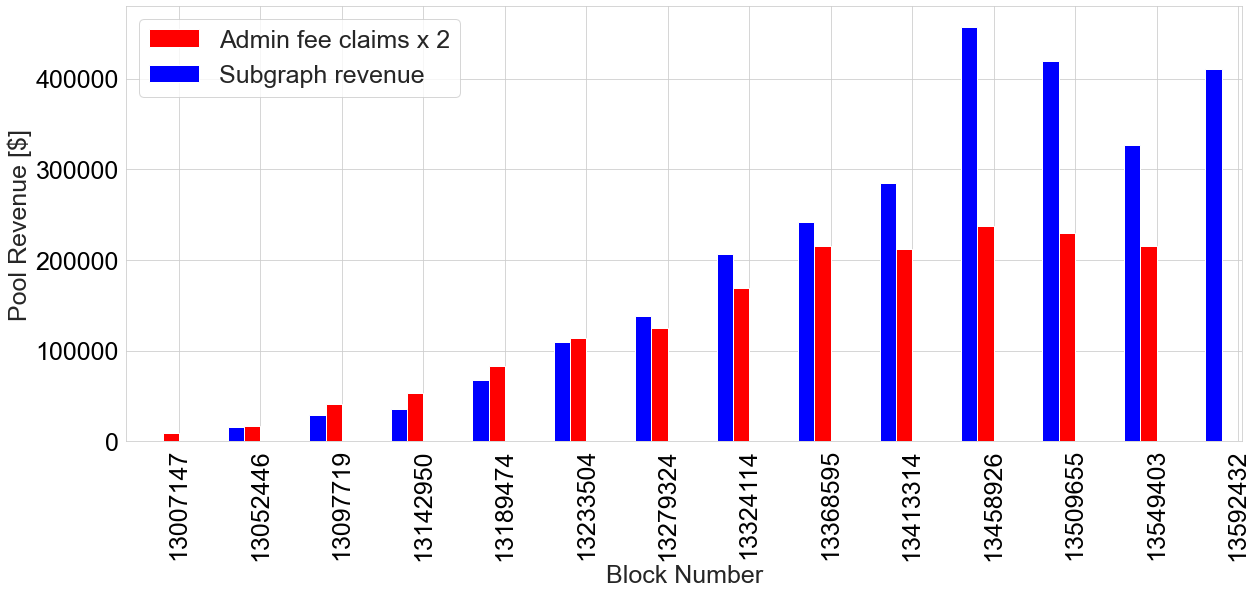

In [34]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_fees']*2).plot(
    ax=ax,
    color='red',
    kind='bar',
    label='Admin fee claims x 2',
    width=0.2,
    position=1,
)
subgraph_tripool_fees['fees'].plot(
    ax=ax,
    color='blue',
    kind='bar',
    label='Subgraph revenue',
    width=0.2,
    position=2,
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);

hmm something strange. let's check admin balances:

In [37]:
with open("./withdraw_admin_fees_txes.json", 'r') as f:
    withdraw_admin_fee_events = json.load(f)['data']['claims']
withdraw_admin_fee_events

[{'block': '13590175',
  'receiver': '0xecb456ea5365865ebab8a2661b0c503410e9b347',
  'timestamp': '1636570051',
  'transaction': '0x1fb617bacef040e74bc73a7054a86276e9bb88c10a7e5108b1be0b874dbd48f6'},
 {'block': '13539610',
  'receiver': '0xecb456ea5365865ebab8a2661b0c503410e9b347',
  'timestamp': '1635884402',
  'transaction': '0x3a09cfa73d297822ef16f1856e7e83e6faed21769e11cc7136dde24a9e64b0cc'},
 {'block': '13497659',
  'receiver': '0xecb456ea5365865ebab8a2661b0c503410e9b347',
  'timestamp': '1635313880',
  'transaction': '0x667db8dc4d89347a4c5e6c4dfd1899399f702de4daf34a6e7571342b5918a8f4'},
 {'block': '13450705',
  'receiver': '0xecb456ea5365865ebab8a2661b0c503410e9b347',
  'timestamp': '1634680333',
  'transaction': '0x4d9dbe9e800bb2b4f01a749f08d87c7c61ba85d44fad5da1b76385c6459d41cd'},
 {'block': '13409100',
  'receiver': '0xecb456ea5365865ebab8a2661b0c503410e9b347',
  'timestamp': '1634115428',
  'transaction': '0x9597c2c26a4bed9a6ce727c1a92dd30a77af50a4bcce359a94abf6a374e816cf'},


In [38]:
pool_addr

'0x5a6A4D54456819380173272A5E8E9B9904BdF41B'

In [39]:
with open("./mim-3pool.json", 'r') as f:
    abi = json.load(f)
mim_3pool = web3.eth.contract(address=pool_addr, abi=abi)

In [50]:
admin_balances_before_claim = []
for claim in withdraw_admin_fee_events:

    block = int(claim['block']) - 1
    admin_balances = (
        mim_3pool.functions.admin_balances(0).call(block_identifier=block)*1e-18,
        mim_3pool.functions.admin_balances(1).call(block_identifier=block)*1e-18,
    )
    admin_balances_before_claim.append(
        {
            "block": block,
            "to_claim": sum(admin_balances)
        }
    )
df_admin_balances = pd.DataFrame(admin_balances_before_claim)
df_admin_balances.index = df_admin_balances.block

In [56]:
aggregated_claims = []
blocks = []
for (block_start, block_end) in subgraph_block_ranges:

    aggregated_claims.append(
        df_admin_balances.to_claim.where(
            (block_start < df_admin_balances.block) & (df_admin_balances.block < block_end)
        ).sum()
    )
    blocks.append(block_end)

aggregated_claims

[4775.209730871071,
 8702.593366681176,
 20551.670923008016,
 26895.26835542624,
 41502.08327220226,
 57355.12654268666,
 63117.76370554969,
 84868.23578872306,
 108795.9736685843,
 106382.41891014391,
 119211.10353512618,
 115467.93325616248,
 108544.58733970037]

In [59]:
df_aggregated_claims = pd.DataFrame(data=aggregated_claims, index=blocks, columns=['to_claim'])
df_aggregated_claims

,to_claim
13052446,4775.209731
13097719,8702.593367
13142950,20551.670923
13189474,26895.268355
13233504,41502.083272
13279324,57355.126543
13324114,63117.763706
13368595,84868.235789
13413314,108795.973669
13458926,106382.418910


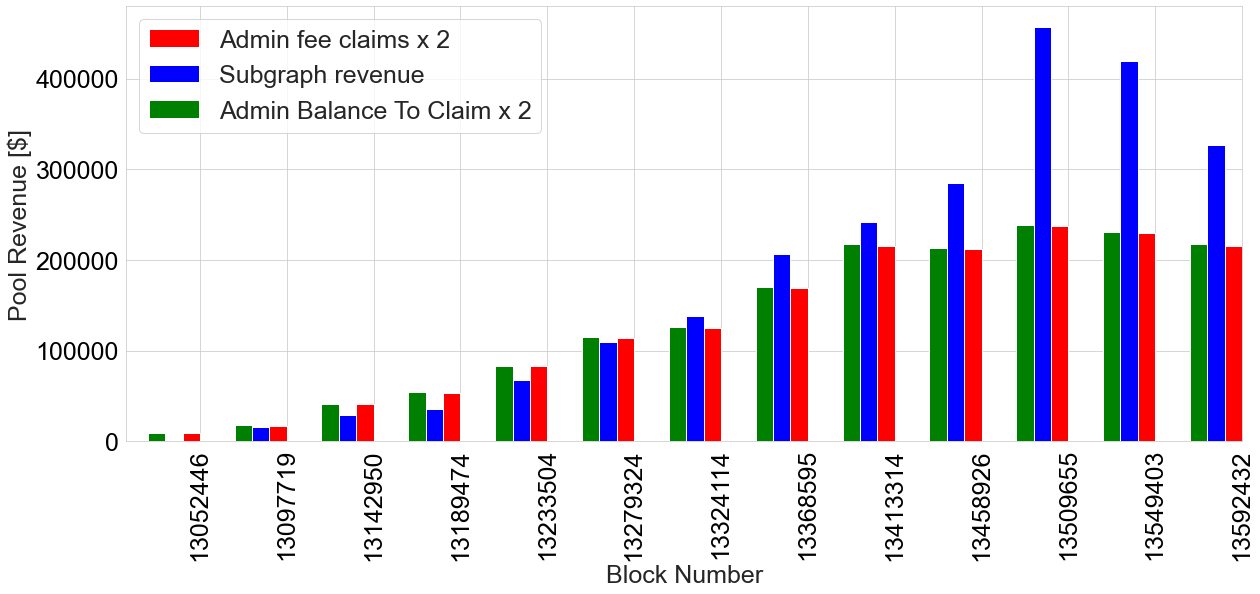

In [61]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_fees']*2).plot(
    ax=ax,
    color='red',
    kind='bar',
    label='Admin fee claims x 2',
    width=0.2,
    position=1,
)
subgraph_tripool_fees['fees'].plot(
    ax=ax,
    color='blue',
    kind='bar',
    label='Subgraph revenue',
    width=0.2,
    position=2,
)
(df_aggregated_claims['to_claim']*2).plot(
    ax=ax,
    color='green',
    kind='bar',
    label='Admin Balance To Claim x 2',
    width=0.2,
    position=3,
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);